In [5]:
import numpy as np
import matplotlib.pyplot as plt
import os
import matplotlib.colors as mcolor
from mpl_toolkits.mplot3d import Axes3D
import numba as nb


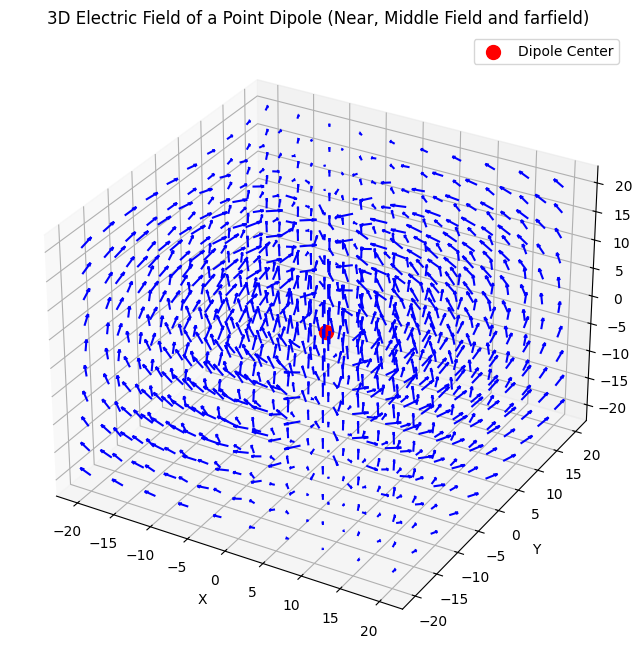

In [3]:
#Short reminder on the dipole field as the phased array is simulated by N dipole emitters
# Define the dipole moment (along the z-axis)
p = np.array([0, 0, 0.1])

# Create a 3D grid
x = np.linspace(-20, 20, 10)
y = np.linspace(-20, 20, 10)
z = np.linspace(-20, 20, 10)
X, Y, Z = np.meshgrid(x, y, z)

# Initialize electric field components
Ex, Ey, Ez = np.zeros(X.shape), np.zeros(Y.shape), np.zeros(Z.shape)

# Compute electric field at each grid point
for i in range(X.shape[0]):
    for j in range(X.shape[1]):
        for k in range(X.shape[2]):
            r = np.array([X[i, j, k], Y[i, j, k], Z[i, j, k]])
            r_mag = np.linalg.norm(r)

            if r_mag == 0:  # Avoid singularity at the dipole location
                continue
            
            r_hat = r / r_mag
            
             # Compute near-field (1/r^3 term)
            E_near = (1 / r_mag**3) * (3 * np.dot(p, r_hat) * r_hat - p)

            # Compute middle-field (1/r^2 term)
            E_middle = -(1 / r_mag**2) * (np.dot(np.dot(r_hat, p), r_hat))  # Fixed sign error

            # Compute far-field (1/r term, radiative term)
            E_far = (1 / r_mag) * np.cross(np.cross(r_hat, p), r_hat)  # Added far-field term

            # Total electric field (Near-field + Middle-field + Far-field)
            E = E_near + E_middle + E_far

            
            # Total electric field (Near-field + Middle-field)
            E = E_near + E_middle + E_far
            
            Ex[i, j, k], Ey[i, j, k], Ez[i, j, k] = E

# Create 3D plot
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection='3d')

# Plot the vector field
ax.quiver(X, Y, Z, Ex, Ey, Ez, length=2, normalize=True, color='b')

# Mark the dipole position
ax.scatter([0], [0], [0], color='r', s=100, label="Dipole Center")

# Labels and title
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")
ax.set_title("3D Electric Field of a Point Dipole (Near, Middle Field and farfield)")
ax.legend()
plt.show()

# Expand to N dipoles at distance d and phase phi

## scan phi

In [ ]:
#use numba
# Define parameters
alpha = np.deg2rad(90) 
p_val = 1 # 1 Debye (~3.3 e-30 Cm) aprox. dipole strength of a molecular emitter
p = np.array([p_val * np.cos(alpha), 0, p_val * np.sin(alpha)])

size = 100000
nano = 1e-9 # m,  used for optical phased array, for radar it would be between 0.03 - 0.3 m
lambda_0 = 600 * nano  # Example wavelength
k = 2 * np.pi / lambda_0  # Wave number
N = 200  # Number of dipoles the higher the better ;)
c = 2.998e8
omega = k * c

dipole_distance = lambda_0*0.5  #can be varried (also interesting ;) )
indices = np.arange(0, N, 1) #for single mode operation. for two mode operation use e.g. np.arange(-(N - 1) // 2, (N - 1) // 2 + 1, dtype=int) to set center dipole to index 0 counting outwards
positions = np.array([[idx * dipole_distance, 0, 0] for idx in indices])  # NumPy array for fast access

# Create 2D grids
x = np.linspace(-size * nano, size * nano, 200)
y = np.linspace(-size * nano, size * nano, 200)
z = np.linspace(-size * nano, size * nano, 200)

X, Z = np.meshgrid(x, z)
X_Y, Y = np.meshgrid(x, y)
Y_Z, Z_Y = np.meshgrid(y, z)


@nb.njit(parallel=True, fastmath=True) # function not yet fully numba optimized but better readable see full numba optimization in next zell ;)
def compute_field(coord1, coord2, coord3, component, positions, indices, phases, p, k):
    grid_shape = coord1.shape
    field = np.zeros(grid_shape, dtype=np.complex128)
    
    for i in nb.prange(grid_shape[0]):  # Parallel loop
        for j in range(grid_shape[1]):
            E_total = np.array([0.0 + 0.0j, 0.0 + 0.0j, 0.0 + 0.0j], dtype=np.complex128)

            for dip_idx in range(len(indices)):
                r = np.array([coord1[i, j], coord2[i, j], coord3[i, j]]) - positions[dip_idx]
                r_mag = np.sqrt(np.sum(r ** 2)) + 1e-12  # Avoid division by zero
                r_hat = r / r_mag
                
                rho = k * r_mag  # Phase argument

                # Compute field components
                dot_pr = np.dot(r_hat, p)
                
                E_near = (1 / rho**3) * (3 * dot_pr * r_hat - p) #not needed for far field evaluation
                E_middle = - (1j / rho**2) * (dot_pr * r_hat - p) #not needed for far field evaluation
                E_far = (1 / rho) * np.cross(np.cross(r_hat, p), r_hat)

                # Apply phase factor 
                phase_factor = np.exp(1j * (rho + phases[dip_idx]))

                E_total += (E_near + E_middle + E_far) * phase_factor

            field[i, j] = E_total[component]

    return field

phase_step = np.arange(0,2,0.2) #adjust min, max phase and for stepsize (here it goes from 0 pi to 2 pi in 0.2 pii steps
    
for n in phase_step:
    phases = np.array([np.absolute(idx) * n* np.pi for idx in indices], dtype=np.complex128)  # Complex dtype for fast operations
    # Compute field components with Numba-accelerated function
    Ex = compute_field(X, np.zeros_like(X), Z, 0, positions, indices, phases, p, k)
    Ez = compute_field(X, np.zeros_like(X), Z, 2, positions, indices, phases, p, k)
    Ey = compute_field(X_Y, Y, np.zeros_like(X_Y), 1, positions, indices, phases, p, k)
    
    # Compute intensity
    E_intensity = np.real(Ex * np.conjugate(Ex) + Ey * np.conjugate(Ey) + Ez * np.conjugate(Ez))
    
    # Plot results
    fig, ax = plt.subplots(figsize=(10, 8))
    norm = mcolor.LogNorm(vmin=E_intensity.min(), vmax=E_intensity.max())
    cmap = ax.pcolormesh(X, Z, E_intensity, cmap='jet', shading='auto', norm=norm)
    plt.colorbar(cmap, ax=ax, label='Real Part of Electric Field Magnitude')
    
    # Labels and title
    ax.set_xlim(-size * nano, size * nano)
    ax.set_ylim(-size * nano, size * nano)
    ax.set_xlabel("X")
    ax.set_ylabel("Z")
    ax.set_title(f"E-field Intensity (X-Z Plane), {N} Dipoles, d={dipole_distance/lambda_0:.2f}λ, phi={np.rad2deg(n* np.pi)}")
    
    # Save and show plot
    #plt.savefig(f"E-field Intensity (X-Z Plane), {N} Dipoles, d={dipole_distance/lambda_0:.2f}λ, phi={np.rad2deg(n* np.pi)}")
    #plt.show()


## Numba optimized code

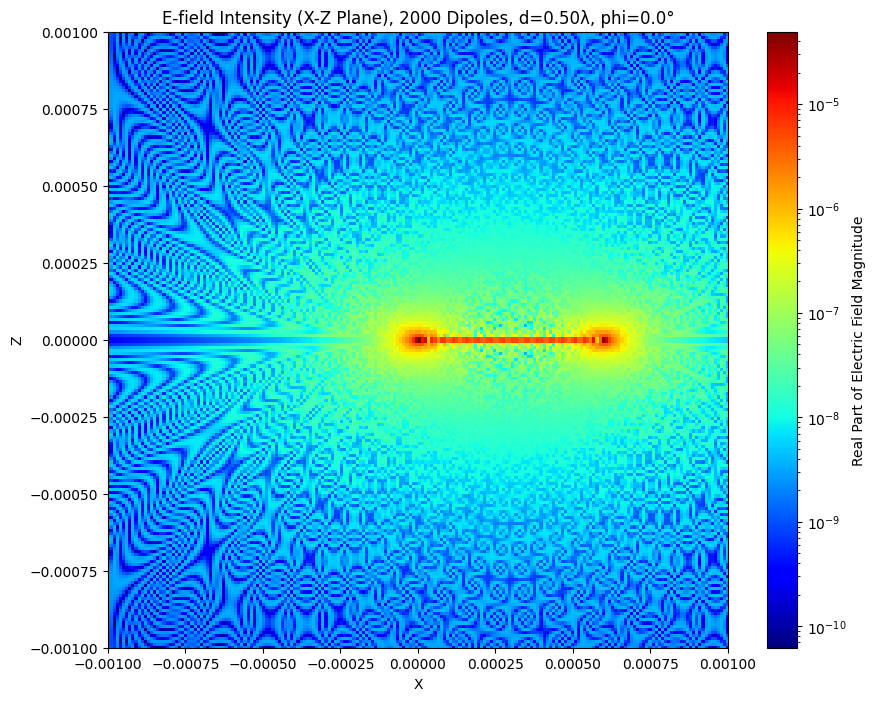

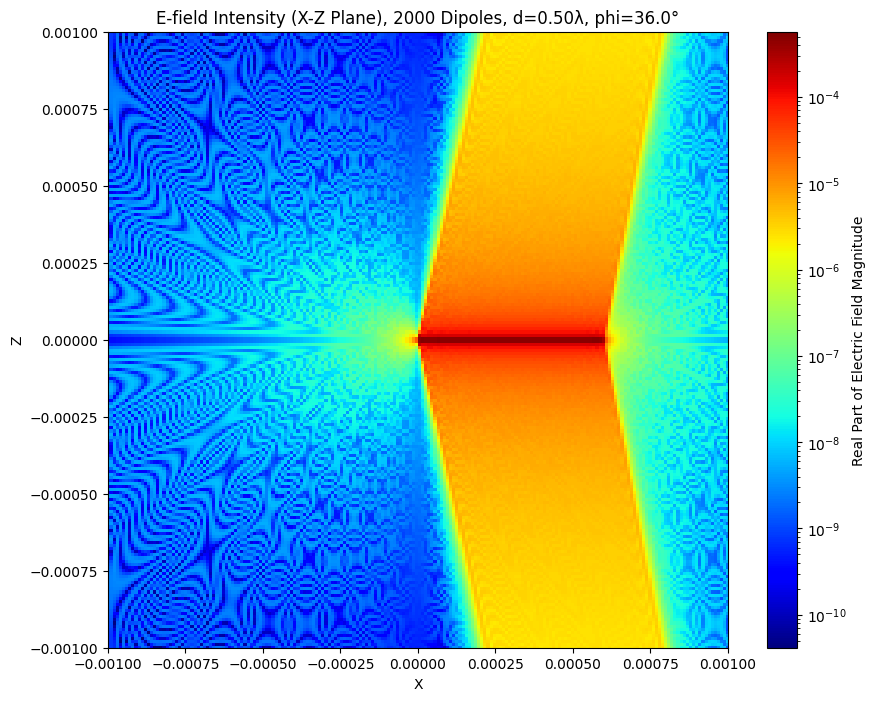

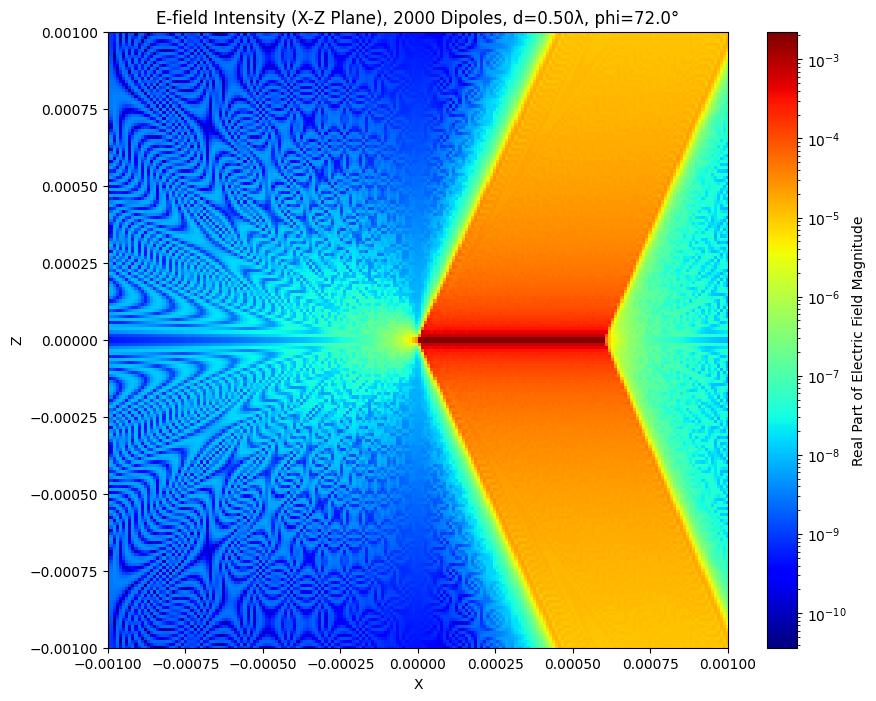

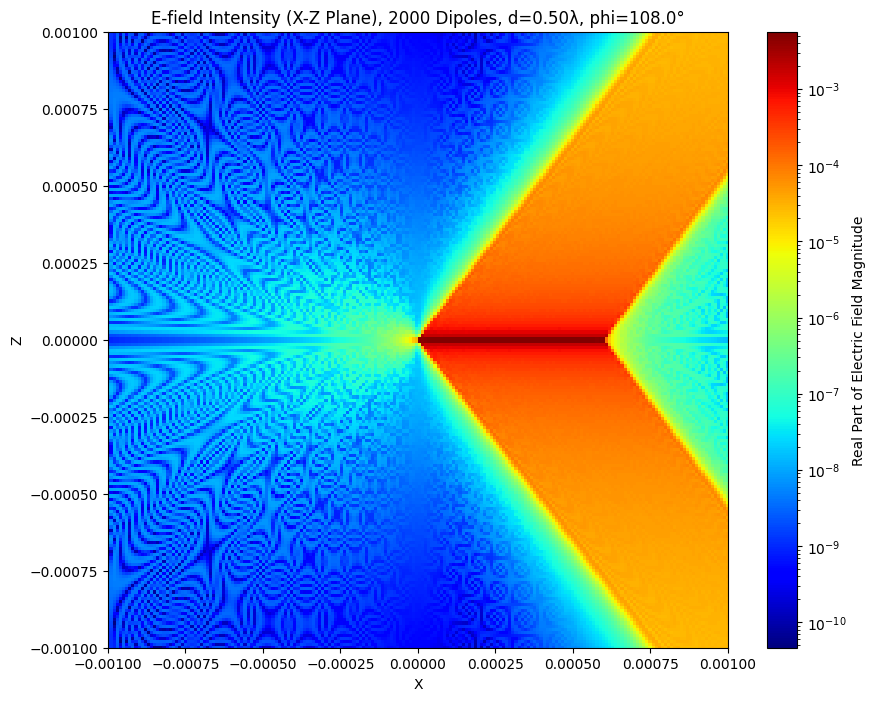

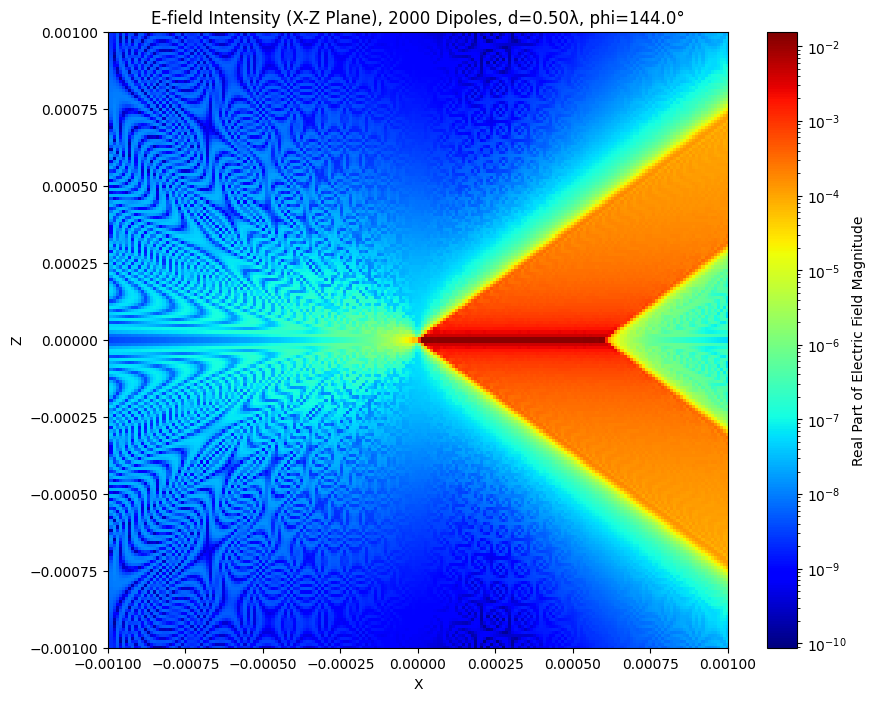

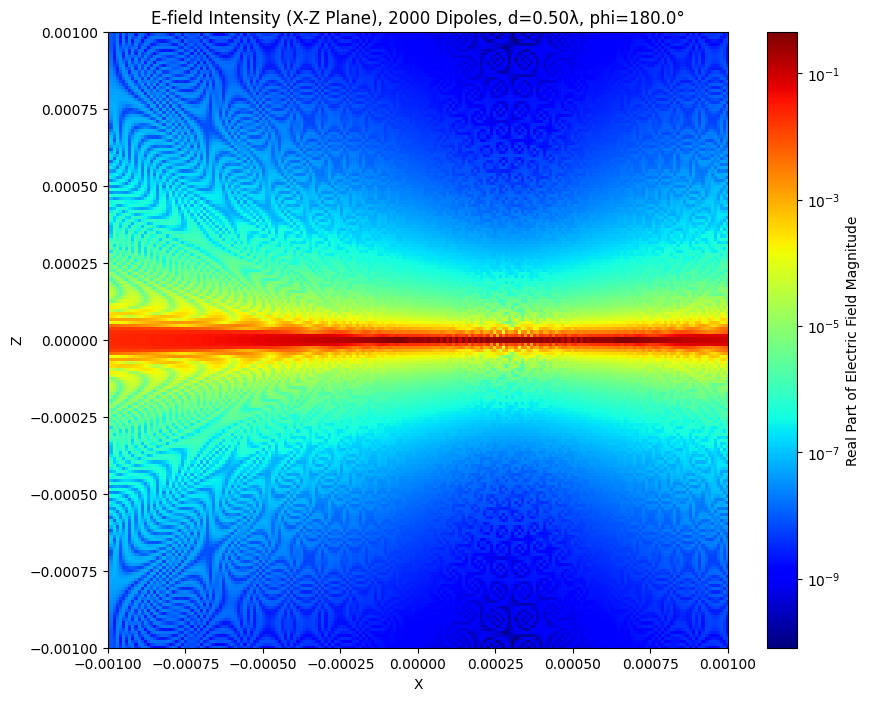

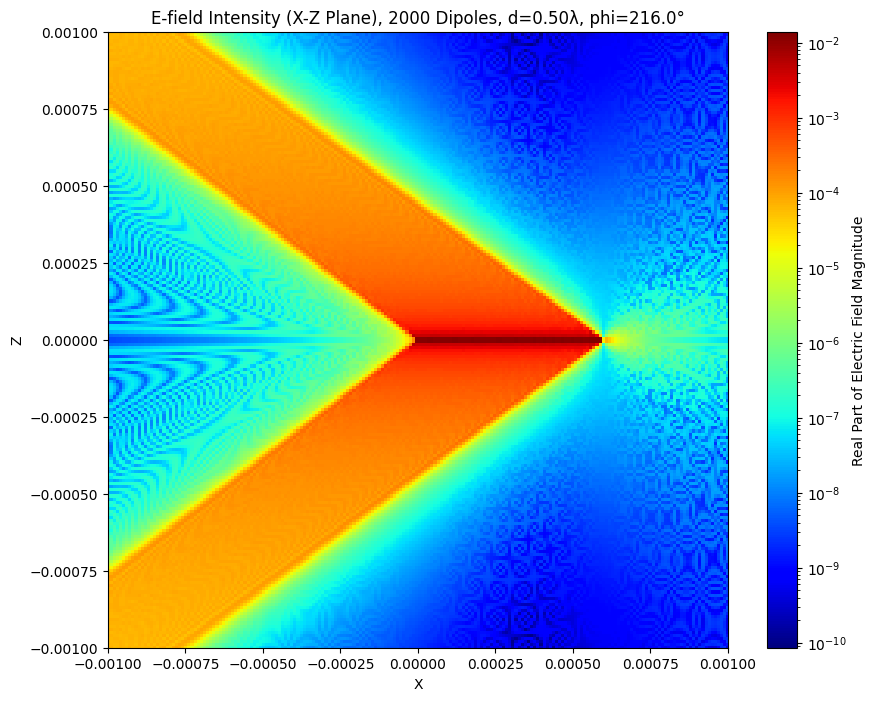

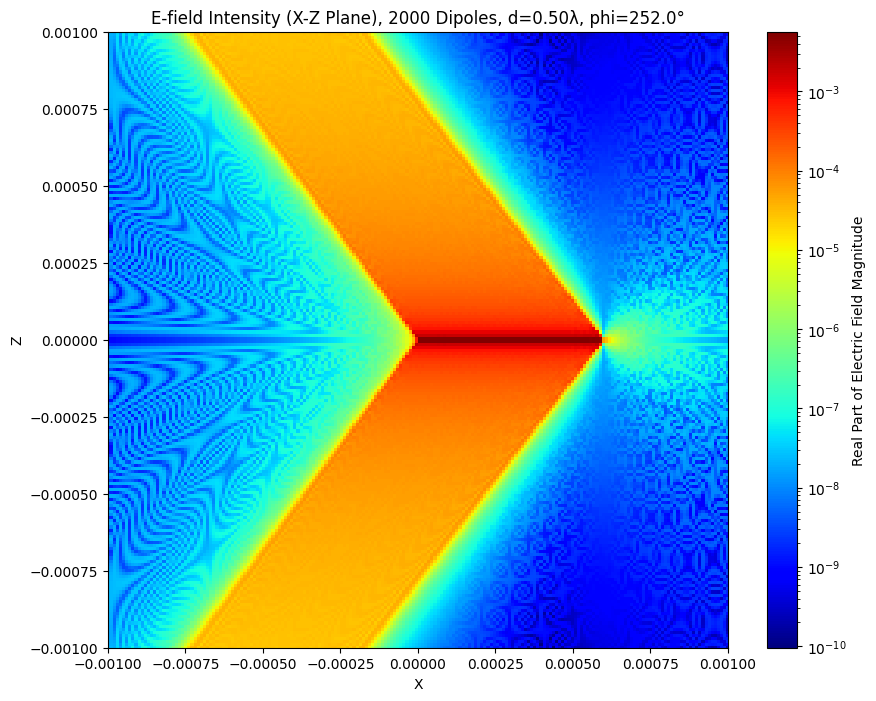

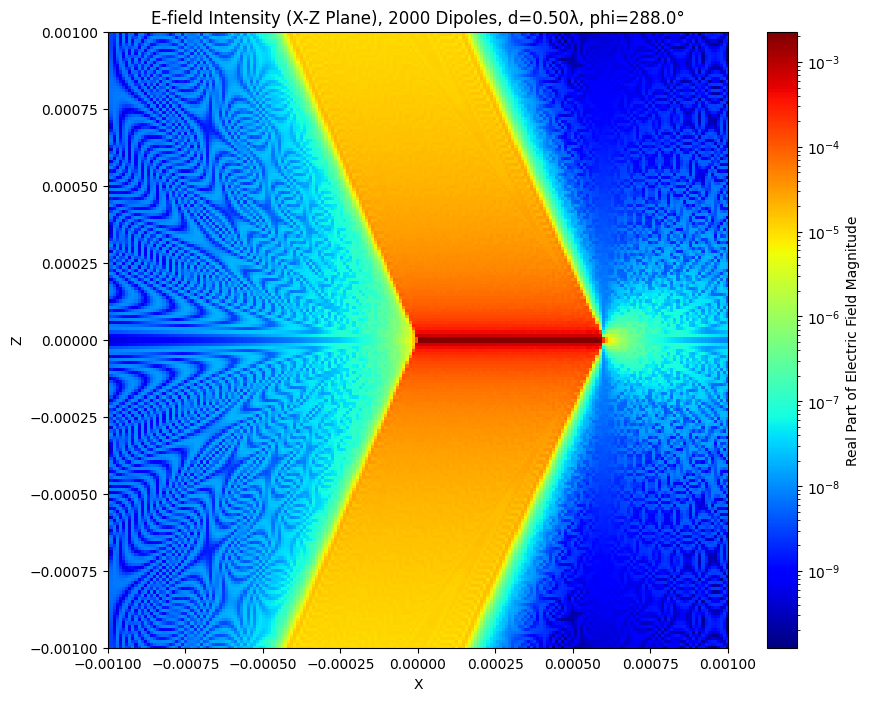

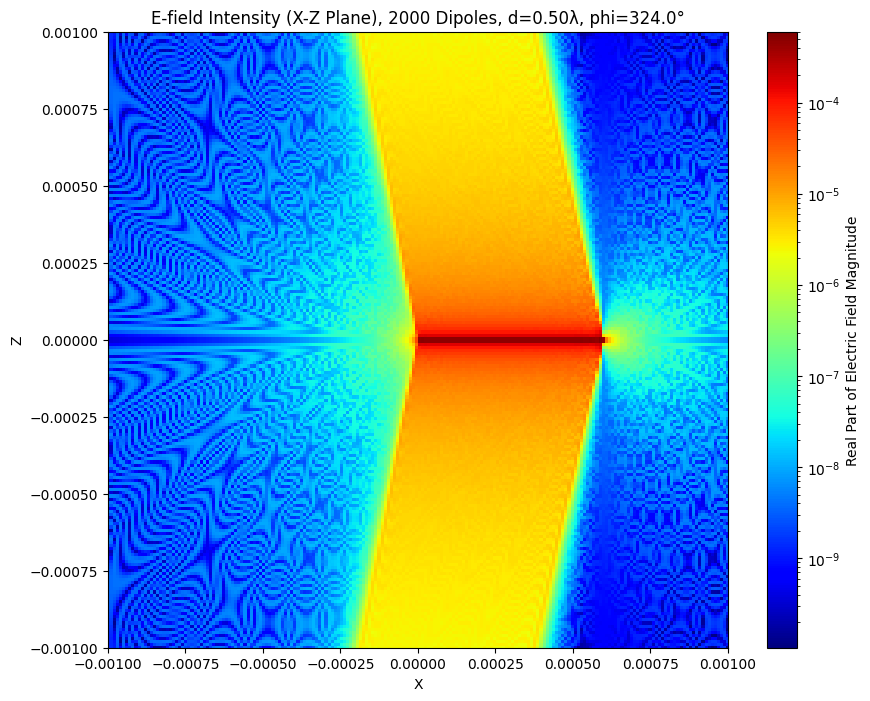

In [16]:
# Same simulation as in the above cell but no np.cross or np.dot, only skalar operation inside loop, using np.ascontiguousarray(...) and define data types
alpha = np.deg2rad(90)
p_val = 1
p = np.array([p_val * np.cos(alpha), 0.0, p_val * np.sin(alpha)], dtype=np.float64)

size = 1000000
nano = 1e-9
lambda_0 = 600 * nano
k = 2.0 * np.pi / lambda_0
N = 2000
c = 2.998e8
omega = k * c

dipole_distance = lambda_0 * 0.5
indices = np.arange(0, N, 1) 
positions = np.ascontiguousarray(
    np.stack([indices * dipole_distance, np.zeros_like(indices, dtype=np.float64), np.zeros_like(indices, dtype=np.float64)], axis=1),
    dtype=np.float64
)

# Grids
x = np.linspace(-size * nano, size * nano, 200, dtype=np.float64)
y = np.linspace(-size * nano, size * nano, 200, dtype=np.float64)
z = np.linspace(-size * nano, size * nano, 200, dtype=np.float64)

X,   Z   = np.meshgrid(x, z, indexing='xy')
X_Y, Y   = np.meshgrid(x, y, indexing='xy')
Y_Z, Z_Y = np.meshgrid(y, z, indexing='xy')

# ensure contiguity 
X  = np.ascontiguousarray(X);   Z  = np.ascontiguousarray(Z)
X_Y = np.ascontiguousarray(X_Y); Y = np.ascontiguousarray(Y)
Y_Z = np.ascontiguousarray(Y_Z); Z_Y = np.ascontiguousarray(Z_Y)

# zeros for fixed-coordinate slices
zeros_XZ = np.zeros_like(X)        # y = 0 plane
zeros_XY = np.zeros_like(X_Y)      # z = 0 plane
zeros_YZ = np.zeros_like(Y_Z)      # x = 0 plane


# Numba-optimized funktion
@nb.njit(parallel=True, fastmath=True, cache=True)
def compute_field(coord1, coord2, coord3, component, positions, phases, p, k):
    """
    coord1, coord2, coord3: 2D float64 arrays of same shape
    component: 0, 1, or 2  (Ex, Ey, Ez)
    positions: (N,3) float64
    phases: (N,) float64  -> phase offsets per dipole (radians)
    p: (3,) float64
    k: float64
    """
    nx, ny = coord1.shape
    out = np.zeros((nx, ny), dtype=np.complex128)

    px, py, pz = p[0], p[1], p[2]
    N = positions.shape[0]
    eps = 1e-18

    for i in nb.prange(nx):
        for j in range(ny):
            # local accumulators
            acc = 0.0 + 0.0j

            x = coord1[i, j]
            y = coord2[i, j]
            z = coord3[i, j]

            for n in range(N):
                rx = x - positions[n, 0]
                ry = y - positions[n, 1]
                rz = z - positions[n, 2]

                r2 = rx*rx + ry*ry + rz*rz
                rmag = np.sqrt(r2) + eps
                inv_r = 1.0 / rmag

                # unit vector r_hat
                rhatx = rx * inv_r
                rhaty = ry * inv_r
                rhatz = rz * inv_r

                # dot(r_hat, p)
                dotpr = rhatx*px + rhaty*py + rhatz*pz # = r̂ · p

                rho = k * rmag
                inv_rho  = 1.0 / rho
                inv_rho2 = inv_rho * inv_rho
                inv_rho3 = inv_rho2 * inv_rho

                # Vector pieces (no cross products instead vector identity is used):
                # v = p - (dotpr) r_hat
                vx = px - dotpr * rhatx
                vy = py - dotpr * rhaty
                vz = pz - dotpr * rhatz # v = p - r̂ (r̂ · p)

                # w = 3 dotpr r_hat - p
                wx = 3.0 * dotpr * rhatx - px
                wy = 3.0 * dotpr * rhaty - py
                wz = 3.0 * dotpr * rhatz - pz

                # Far:     (1/rho)   * v
                # Middle:  -(1j/rho^2)* v
                # Near:    (1/rho^3) * w
                if component == 0:   # Ex
                    comp = inv_rho * vx - (0.0 + 1.0j) * inv_rho2 * vx + inv_rho3 * wx
                elif component == 1: # Ey
                    comp = inv_rho * vy - (0.0 + 1.0j) * inv_rho2 * vy + inv_rho3 * wy
                else:                # Ez
                    comp = inv_rho * vz - (0.0 + 1.0j) * inv_rho2 * vz + inv_rho3 * wz

                theta = rho + phases[n]
                c = np.cos(theta)
                s = np.sin(theta)
                phase = c + 1.0j * s  # e^{i theta}

                acc += comp * phase

            out[i, j] = acc

    return out


phase_step = np.arange(0.0, 2.0, 0.2) 

zeros_XZ = np.zeros_like(X)            # avoid recreating every loop
zeros_XY = np.zeros_like(X_Y)

for n in phase_step:
    # per-dipole phase offsets in radians
    phases = np.ascontiguousarray(np.abs(indices).astype(np.float64) * n * np.pi)

    # Compute field components
    Ex = compute_field(X,        zeros_XZ, Z,        0, positions, phases, p, k)
    Ez = compute_field(X,        zeros_XZ, Z,        2, positions, phases, p, k)
    Ey = compute_field(X_Y,      Y,        zeros_XY, 1, positions, phases, p, k)

    # Intensity
    E_intensity = np.real(Ex * np.conjugate(Ex) +
                          Ey * np.conjugate(Ey) +
                          Ez * np.conjugate(Ez))

    # Plot 
    fig, ax = plt.subplots(figsize=(10, 8))
    norm = mcolor.LogNorm(vmin=E_intensity.min(), vmax=E_intensity.max())
    pc = ax.pcolormesh(X, Z, E_intensity, cmap='jet', shading='auto', norm=norm)
    plt.colorbar(pc, ax=ax, label='Real Part of Electric Field Magnitude')

    ax.set_xlim(-size * nano, size * nano)
    ax.set_ylim(-size * nano, size * nano)
    ax.set_xlabel("X")
    ax.set_ylabel("Z")
    ax.set_title(f"E-field Intensity (X-Z Plane), {N} Dipoles, d={dipole_distance/lambda_0:.2f}λ, "
                 f"phi={np.rad2deg(n*np.pi):.1f}°")
    plt.show()
